#  프로젝트 : 네이버 영화리뷰 감성분석 도전하기

이전 스텝까지는 영문 텍스트의 감정분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.https://github.com/e9t/nsmc
아래와 같이 다운로드를 진행해 주세요.
```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification
```


# 1) 데이터 준비 확인

In [7]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')




 ### 상위 5개 출력

In [8]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 하위 5개 출력

In [9]:
train_data.tail()

,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


 ####  Nsmc데이터는 id, document, label 총 3개의 열로 구성

In [10]:
print('테스트용 리뷰 개수 :',len(train_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 150000


In [11]:
train_data.info() # infor를 통해 train 정보 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


# 2) 데이터로더 구성    
nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일이다.자신만의 data_loader를 만들어 보자 

- 데이터의 중복 제거
- NaN 결측치 제거
- 각종 특수문자제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 단어 집합 만들기(추가)
- 노드 제공 코드 사용하기

In [12]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
#데이터의 중복 제거
#NaN 결측치 제거
#각종 특수문자제거
#한국어 토크나이저로 토큰화
#불용어(Stopwords) 제거
#사전word_to_index 구성
#텍스트 스트링을 사전 인덱스 스트링으로 변환
#X_train, y_train, X_test, y_test, word_to_index 리턴

# 데이터의 중복 제거

https://wikidocs.net/44249

In [13]:
train_data['document'].nunique(), train_data['label'].nunique() # 중복을 제거한 단어수

(146182, 2)

#### 총 150,000개의 샘플이 존재하는데 document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 약 4,000개의 중복 샘플이 존재한다는 의미다.label 열은 0 또는 1의 값만을 가지므로 2가 출력됨

In [14]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

#### document 열에서 중복인 내용이 있다면 중복 제거한다.

In [15]:
train_data.info() # infor를 통해 train 정보 출력

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146183 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146183 non-null  int64 
 1   document  146182 non-null  object
 2   label     146183 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


#### 위는 중복 제거후 정보이다. 중복 제거 전 정보를 가져와 보겠다. 비교해보자
 ```
 0   id        150000 non-null  int64    
 1   document  149995 non-null  object  
 2   label     150000 non-null  int64   
 ```
####  중복데이터가 제거된것이 확인된다.

<AxesSubplot:>

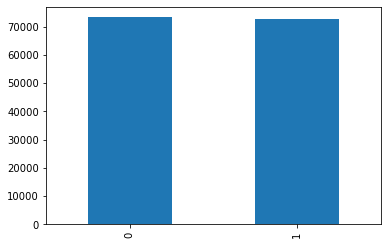

In [16]:
train_data['label'].value_counts().plot(kind = 'bar')

#### train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(label)분포그래프

# NAN(not a NUMber)데이터 제거하기

- #### NAN : 표현이 불가능한 수치형 데이터를 NAN이라고한다 NULL과 같은 의미
- #### 참고 내용 :머신러닝 알고리즘이 작동하기 위해서는 각 feature수치형 데이터로 채워 feature vector로 만들어야 한다. 이 과정 feature engineering이라고 하며, 그 과정 중에 하나가 NaN데이터 처리를 처리하는 과정이다.

https://dsbook.tistory.com/21  

https://blog.naver.com/PostView.nhn?blogId=youji4ever&logNo=221712578078

In [17]:
train_data.isna().sum()
#isna() NaN인지 아닌지 boolean데이터로 반환
#sum() 반환된 boolean 데이터 중 True 값만 count


id          0
document    1
label       0
dtype: int64

#### Nsmc 에서 NAN 값은 document열에 1개가 있다는것을 알수 있다.

In [18]:
train_data.loc[train_data.document.isnull()] # 특정열 NAN 확인하기

,id,document,label
25857,2172111,NaN,1


#### docment에 NAN이 존재 확인됨

In [19]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

#### dropna함수 사용해서 NaN데이터가 있는 row를 삭제한다.

In [20]:
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [21]:
train_data.info() # infor를 통해 train 정보 출력

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


#### NAN값이 제거되어서 id,document,label 개수가 동일해짐

#  각종 특수문자제거
 - #### 온점(.) 물음표(?),느낌표(!) 와 같은 각종 특수문자를 제거하자
 - #### 일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있습니다
 ```
ㄱ ~ ㅎ: 3131 ~ 314E
ㅏ ~ ㅣ: 314F ~ 316위
가 ~ 힣 : 
```
#### 자음모음 범위: https://www.unicode.org/charts/PDF/U3130.pdf   
#### 완성형 범위 :https://www.unicode.org/charts/PDF/UAC00.pdf

In [22]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


#### 기존에 한글이 없는 리뷰였다면 이제 더 이상 아무런 값도 없는 빈(empty) 값을 가질것이다. (NULL과 다른의미)

In [23]:
train_data['document'].replace('', np.nan, inplace=True) # 빈공간을 NULL로 적용하기
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


#### 빈 값을 가진 행이 있다면 Null 값으로 변경하고 개수를 확인하면 NAN를 가진 document가 391개나 된다.

In [24]:
train_data.loc[train_data.document.isnull()][:7]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1
1840,7095375,NaN,1
2073,384233,NaN,1


#### 391개 중 7개 출력

In [25]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


#### NAN값 모두 제거

In [26]:
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [27]:
train_data.info() # infor를 통해 train 정보 출력

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145791 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145791 non-null  int64 
 1   document  145791 non-null  object
 2   label     145791 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


## test_data 테스트데이터도 똑같은 전처리 적용하기

In [28]:
### 
test_data.drop_duplicates(subset = ['document'], inplace=True) # 중복제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글 외 특수문제 제거
test_data['document'].replace('', np.nan, inplace=True) # 빈(empty)공간 NAN로 변경
test_data = test_data.dropna(how='any') # NAN(NULL)값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))
test_data.info() # infor를 통해 test 정보 출력

전처리 후 테스트용 샘플의 개수 : 48995
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48995 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48995 non-null  int64 
 1   document  48995 non-null  object
 2   label     48995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


### 테스트 데이터 : 48417개

# 한국어 토크나이저로 토큰화 & 불용어(Stopwords) 제거

 - 토큰화 과정에서 불용어를 제거한다. 
 - 불용어 : 한국어의 조사, 접속사 등(문장에 자주 등장하지만 문자자체에 큰 의미가 없는 문자)https://wikidocs.net/22530
 - 딥러닝에는 불용어는 그 환경에 맞게 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많다.
 - 토큰화를 위한 형태소 분석기는 KoNLPy의 Mecab()를 사용 /Okt
 - 형태소 분석기 종류 https://passerby14.tistory.com/3
 - 영어는 띄어쓰기 기준으로 토큰화한다. 한국어는 띄어쓰기가 아닌 형태소 분석기로 토큰화한다.



In [29]:
from konlpy.tag import Mecab
mecab = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

### mecab형태소 분석기로 토큰화

In [30]:
sample = mecab.morphs('와 주말인데 컴퓨터 앞에서 과제하는 나 레전드다.')
print(sample)

['와', '주말', '인데', '컴퓨터', '앞', '에서', '과제', '하', '는', '나', '레전드', '다', '.']


### 불용어 제거  ( '와' ,'는'  제거 )

In [31]:
sample = [word for word in sample if not word in stopwords] # 불용어(Stopwords) 제거
print(sample)

['주말', '인데', '컴퓨터', '앞', '에서', '과제', '하', '나', '레전드', '다', '.']


## 한국어 토크나이저로 토큰화 & 불용어(Stopwords) 제거 코드

In [32]:
# Mecab()사용
from konlpy.tag import Mecab
mecab = Mecab()
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = mecab.morphs(sentence) # 토큰화(Tokenization)
    #temp_X = mecab.morphs(sentence, stem=True) # 토큰화(Tokenization)
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어(Stopwords) 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = mecab.morphs(sentence) # 토큰화(Tokenization)
    temp_X = [word for word in temp_X if not word in stopwords]# 불용어(Stopwords) 제거
    X_test.append(temp_X)

# 훈련 데이터에 대해서 단어 집합(vocaburary)


In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

### 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 

In [34]:
#print(tokenizer.word_index) 단어가 49946개가 존재
total_cnt = len(tokenizer.word_index) # 단어의 수

#### 각 정수들은 등장 빈도수가 높은 순서대로 분여됨. 그래서 우리는 빈도가 낮은 단어들을 자연어 처리에서 배재하겠다.
#### 밑 코드를 활용하여 등장 빈도수가 3회 미만인 단어들이 이 데이터의 비중을 확인해 보겠다.

In [35]:
threshold = 3 # 빈도가 threshold 값인 3회 미만 판별을 위한 변수
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 49946
등장 빈도가 2번 이하인 희귀 단어의 수: 28320
단어 집합에서 희귀 단어의 비율: 56.70123733632323
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7606762208782198


#### 등장빈도가 2번 이하인 단어수는 28320개로 절반이상수를 가지고 있다.
#### 하지만 전제 등장 빈도는 1.87%밖에 되지 않는다.즉 2회 이하의 단어들은 자연어 처리에 중요하지 않다는 의미이다. 이 2회 이하인 단어들은 제거하겠다.


In [36]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21628


#### 49946 - 28320 로써 21628값만 남게 된다.

### 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다.https://wikidocs.net/44249
```
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
```
### 허나 노드에서는 다른 방식을 사용함으로 노드 방식 따르겠다.
예시답안이 없는줄 알고 일일히 찾다가 있다는걸 알았다. 지금부터 노드에서 제공하는 코드를 활용하자.



# 노드 제공 코드 사용하기

# 1) 데이터 준비 확인


In [37]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')


# 2) 데이터로더 구성

In [38]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# 데이터의 중복 제거   
# NaN 결측치 제거   
# 한국어 토크나이저로 토큰화   
# 불용어(Stopwords) 제거   
# 사전word_to_index 구성   
# 텍스트 스트링을 사전 인덱스 스트링으로 변환   
# X_train, y_train, X_test, y_test, word_to_index 리턴  

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    ## X_train, y_train, X_test, y_test, word_to_index 리턴    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [39]:
# index to text 사전
index_to_word = {index:word for word, index in word_to_index.items()}
type(index_to_word)
for index,word in index_to_word.items():
    print(index,word)
    if index == 20:
        break

0 <PAD>
1 <BOS>
2 <UNK>
3 <UNUSED>
4 .
5 영화
6 다
7 고
8 하
9 을
10 보
11 ..
12 게
13 ,
14 !
15 지
16 있
17 없
18 ?
19 좋
20 나


In [40]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정

### pad_sequences를 통해 데이터셋의 문장 길이 통일
### 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향 미친다. 

In [41]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [42]:
#RNN은 입력데이터가 순차적으로 처리되기 때문에 뒤부분 입력이 패딩값(padding)으로 채워지면 비효율적이다.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value=word_to_index["<PAD>"],
                                                     padding='pre',# 혹은'post'
                                                     maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre', # 혹은 'post'
                                                    maxlen=maxlen)
print(X_train.shape)

(146182, 41)


### RNN은 입력데이터가 순차적으로 처리되기 때문에 뒤부분 입력이 패딩값(padding)으로 채워지면 비효율적이다. 
pre는 앞에서부터 0이 채워짐, post는 뒤에서부터 0이 채워짐

# 4) 모델구성 및 validation set 구성
 - 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [43]:
# model 설계

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


#LSTM
model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(keras.layers.SpatialDropout1D(0.4))
model_LSTM.add(keras.layers.LSTM(word_vector_dim, dropout=0.2, recurrent_dropout=0.2))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다.
model_LSTM.add(keras.layers.Dense(8, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


#Conv1D
model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


#GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
#전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
model_GlobMP = keras.Sequential()
model_GlobMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GlobMP.add(keras.layers.GlobalMaxPooling1D())
#model_GlobMP.add(keras.layers.Dropout(0.3))
model_GlobMP.add(keras.layers.Dense(8, activation='relu'))
#model_GlobMP.add(keras.layers.Dropout(0.3))
model_GlobMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()
model_CNN.summary()
model_GlobMP.summary()




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 16)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 162,

In [44]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(X_train.shape)
print(y_train.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(146182, 41)
(146182,)
(136182, 41)
(136182,)


# 5) 모델 훈련 개시

In [45]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model_LSTM = model_LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model_LSTM.evaluate(X_test,  y_test, verbose=2)
print(results)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 136182 samples, validate on 10000 samples
Epoch 1/10
136182/136182 [==============================] - 7s 55us/sample - loss: 0.4952 - acc: 0.7639 - val_loss: 0.3606 - val_acc: 0.8447
Epoch 2/10
136182/136182 [==============================] - 7s 50us/sample - loss: 0.3630 - acc: 0.8451 - val_loss: 0.3435 - val_acc: 0.8533
Epoch 3/10
136182/136182 [==============================] - 7s 50us/sample - loss: 0.3430 - acc: 0.8566 - val_loss: 0.3390 - val_acc: 0.8530
Epoch 4/10
136182/136182 [==============================] - 7s 49us/sample - loss: 0.3327 - acc: 0.8619 - val_loss: 0.3406 - val_acc: 0.8535
Epoch 5/10
136182/136182 [==============================] - 7s 49us/sample - loss: 0.3248 - acc: 0.8652 - val_loss: 0.3426 - val_acc: 0.8538
Epoch 6/10
136182/136182 [==============================] - 7s 50us/sample - loss: 0.3177 - acc: 0.8691 - val_loss: 0.3394 - val_acc: 0.8555
Epoch 7/1

In [46]:
model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model_CNN= model_CNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
                           
# 테스트셋을 통한 모델 평가
results = model_CNN.evaluate(X_test,  y_test, verbose=2)
print(results)


Train on 136182 samples, validate on 10000 samples
Epoch 1/10
136182/136182 [==============================] - 2s 16us/sample - loss: 0.5057 - acc: 0.7355 - val_loss: 0.3530 - val_acc: 0.8471
Epoch 2/10
136182/136182 [==============================] - 2s 14us/sample - loss: 0.3325 - acc: 0.8583 - val_loss: 0.3391 - val_acc: 0.8511
Epoch 3/10
136182/136182 [==============================] - 2s 13us/sample - loss: 0.3030 - acc: 0.8729 - val_loss: 0.3341 - val_acc: 0.8575
Epoch 4/10
136182/136182 [==============================] - 2s 14us/sample - loss: 0.2814 - acc: 0.8842 - val_loss: 0.3349 - val_acc: 0.8568
Epoch 5/10
136182/136182 [==============================] - 2s 13us/sample - loss: 0.2597 - acc: 0.8953 - val_loss: 0.3362 - val_acc: 0.8568
Epoch 6/10
136182/136182 [==============================] - 2s 14us/sample - loss: 0.2357 - acc: 0.9072 - val_loss: 0.3476 - val_acc: 0.8529
Epoch 7/10
136182/136182 [==============================] - 2s 14us/sample - loss: 0.2101 - acc: 0.9197

In [47]:
model_GlobMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model_GlobMP= model_GlobMP.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

               
# 테스트셋을 통한 모델 평가
results = model_GlobMP.evaluate(X_test,  y_test, verbose=2)
print(results)

Train on 136182 samples, validate on 10000 samples
Epoch 1/10
136182/136182 [==============================] - 1s 9us/sample - loss: 0.5945 - acc: 0.7450 - val_loss: 0.4301 - val_acc: 0.8246
Epoch 2/10
136182/136182 [==============================] - 1s 8us/sample - loss: 0.3780 - acc: 0.8399 - val_loss: 0.3570 - val_acc: 0.8421
Epoch 3/10
136182/136182 [==============================] - 1s 7us/sample - loss: 0.3286 - acc: 0.8610 - val_loss: 0.3475 - val_acc: 0.8474
Epoch 4/10
136182/136182 [==============================] - 1s 8us/sample - loss: 0.3030 - acc: 0.8738 - val_loss: 0.3471 - val_acc: 0.8470
Epoch 5/10
136182/136182 [==============================] - 1s 8us/sample - loss: 0.2838 - acc: 0.8827 - val_loss: 0.3519 - val_acc: 0.8473
Epoch 6/10
136182/136182 [==============================] - 1s 8us/sample - loss: 0.2688 - acc: 0.8901 - val_loss: 0.3555 - val_acc: 0.8482
Epoch 7/10
136182/136182 [==============================] - 1s 8us/sample - loss: 0.2562 - acc: 0.8966 - val_

### 실행속도가 global_max_pooling > CNN > LSTM 으로 빠르다.

# 6) Loss, Accuracy 그래프 시각화

### 3개의 모델에 대한 history 가져오기

In [48]:
#history_model_CNN
#history_model_LSTM
#history_model_GlobMP
history_dict_CNN = history_model_CNN.history
history_dict_LSTM = history_model_LSTM.history
history_dict_GlobMP = history_model_GlobMP.history
print(history_dict_GlobMP.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


history에 4개의 값이 존재한다.

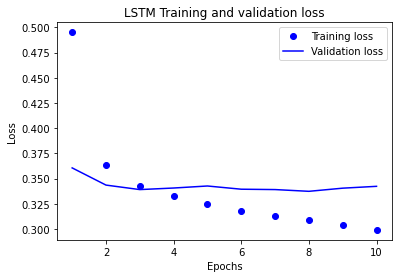

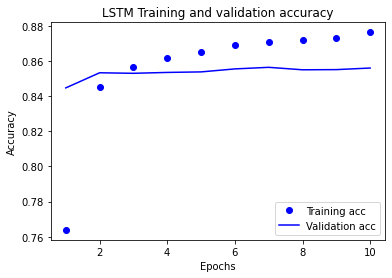

In [49]:
import matplotlib.pyplot as plt

acc = history_dict_LSTM['acc']
val_acc = history_dict_LSTM['val_acc']
loss = history_dict_LSTM['loss']
val_loss = history_dict_LSTM['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음




# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

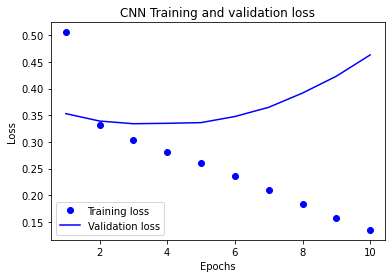

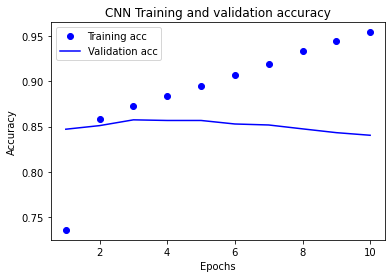

In [50]:
import matplotlib.pyplot as plt

acc = history_dict_CNN['acc']
val_acc = history_dict_CNN['val_acc']
loss = history_dict_CNN['loss']
val_loss = history_dict_CNN['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

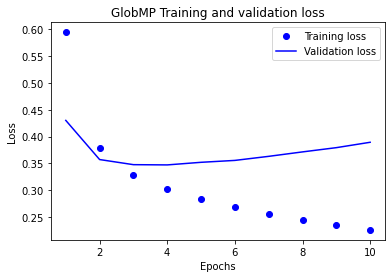

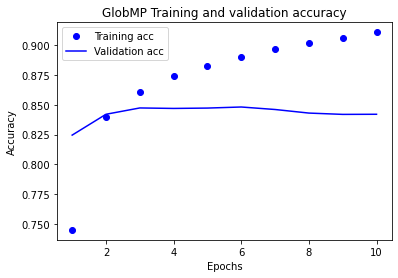

In [51]:
import matplotlib.pyplot as plt

acc = history_dict_GlobMP['acc']
val_acc = history_dict_GlobMP['val_acc']
loss = history_dict_GlobMP['loss']
val_loss = history_dict_GlobMP['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음




# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobMP Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobMP Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [52]:
#history_model_LSTM
#history_model_CNN
#history_model_GlobMP
embedding_layer = model_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


### LSTM학습된 임베딩 파라미터를 word_project01.txt에 저장

In [53]:
import os
# word2vec변수명 오류 추후 변경
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.(word2vec_project파일명) 
word_file_path01 = os.getenv('HOME')+'/aiffel/sentiment_classification/word_project01.txt'
f = open(word_file_path01, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors01 = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors01[i, :])))))
f.close()

### CNN학습된 임베딩 파라미터를 word_project02.txt에 저장

In [54]:
import os
# word2vec변수명 오류 추후 변경
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.(word2vec_project파일명) 
word_file_path02 = os.getenv('HOME')+'/aiffel/sentiment_classification/word_project02.txt'
f = open(word_file_path02, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors02 = model_CNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors02[i, :])))))
f.close()

### global_max_pooling 학습된 임베딩 파라미터를 word_project03.txt에 저장

In [55]:
import os
import gensim
# word2vec변수명 오류 추후 변경
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.(word2vec_project파일명) 
word_file_path03 = os.getenv('HOME')+'/aiffel/sentiment_classification/word_project03.txt'
f = open(word_file_path03, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors03 = model_GlobMP.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors03[i, :])))))
f.close()

In [56]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# word2vec변수명 오류 추후 변경
word_vectors01 = Word2VecKeyedVectors.load_word2vec_format(word_file_path01, binary=False)
word_vectors02 = Word2VecKeyedVectors.load_word2vec_format(word_file_path02, binary=False)
word_vectors03 = Word2VecKeyedVectors.load_word2vec_format(word_file_path03, binary=False)
vector01 = word_vectors01['한국']
#vector02 = word_vectors02['한국']
#vector03 = word_vectors03['한국']
vector01

array([ 0.00908837, -0.00622601, -0.02160037,  0.0295243 ,  0.0084301 ,
       -0.02788573, -0.1068683 ,  0.0248739 ,  0.01308374, -0.00616497,
       -0.00168382,  0.03066642, -0.0519398 ,  0.03592556,  0.03426271,
        0.06425191], dtype=float32)

In [57]:
#LSTM학습된 임베딩
word_vectors01.similar_by_word("코믹") 

[('푸하하', 0.7758907079696655),
 ('눌', 0.7536205053329468),
 ('알려진', 0.7290761470794678),
 ('다만', 0.7052249908447266),
 ('놀래키', 0.697749137878418),
 ('are', 0.6934356689453125),
 ('막히', 0.6862187385559082),
 ('조각', 0.6839176416397095),
 ('콘', 0.6821603178977966),
 ('조심', 0.6803556680679321)]

In [58]:
#CNN 학습된 임베딩
word_vectors02.similar_by_word("코믹")

[('욕할', 0.8446875214576721),
 ('나와라', 0.8352764844894409),
 ('신', 0.6736786365509033),
 ('웡', 0.6550073623657227),
 ('가능', 0.6390863060951233),
 ('영혼', 0.6297447681427002),
 ('밑', 0.6291113495826721),
 ('들어와서', 0.6287700533866882),
 ('추격', 0.6268680095672607),
 ('엔딩', 0.6179618835449219)]

In [59]:
#global_max_pooling 학습된 임베딩
word_vectors03.similar_by_word("코믹")

[('일단', 0.8962787389755249),
 ('단편', 0.8808010816574097),
 ('대학생', 0.8780936002731323),
 ('현지', 0.8686161041259766),
 ('파헤치', 0.8651931881904602),
 ('아무튼', 0.8601528406143188),
 ('저게', 0.8533568382263184),
 ('화장실', 0.8498263359069824),
 ('기법', 0.8492023944854736),
 ('우물', 0.8474480509757996)]

LTSL, CNN, 단일global_max_pooling 의 모델의 학습의 결과로 위같이 '코믹'라는 단어와 유사도를 위같이 보여줍니다.    
(워드벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인방법)   
확인한 결과 유사도 좋지않은 결과가 나옵니다. 그래서 학습된 한국어 임베딩를 활용하는법을 밑에서 수행해보겠습니다.

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
- 한국어 Word2Vec은 다음 경로에서 구할 수 있습니다 https://github.com/Kyubyong/wordvectors
- F파일과 W파일이 있었는데 W만 잘 돌아갔다.   
- https://wikidocs.net/50739 참조 (gensim.models.Word2Vec.load(word2vec_file_path_ko))
-  Word2vec 모델은 자연어 처리에서 단어를 밀집 벡터로 만들어주는 단어 임베딩 방법론이지만 최근에 들어서는 자연어 처리를 넘어서 추천 시스템에도 사용되고 있는 모델입니다. 우선 적당하게 데이터를 나열해주면 Word2vec은 위치가 근접한 데이터를 유사도가 높은 벡터를 만들어준다는 점에서 착안된 아이디어입니다.

In [60]:
# 미리 훈련된 임베딩 가져오기
import os
import gensim
word2vec_file_path_ko = os.getenv('HOME')+'/aiffel/sentiment_classification/w/ko.bin'
word_vectors_ko = gensim.models.Word2Vec.load(word2vec_file_path_ko)
#vector_ko = word_vectors_ko['한국']
#vector_ko

In [61]:
word_vectors_ko.similar_by_word("코믹") 

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('매거진', 0.710258960723877),
 ('코믹스', 0.6731104850769043),
 ('만화', 0.618959903717041),
 ('잡지', 0.617271900177002),
 ('미스터리', 0.6109945774078369),
 ('문고', 0.5955140590667725),
 ('마켓', 0.5947057008743286),
 ('단샤', 0.5901690721511841),
 ('동인지', 0.584815263748169),
 ('스페셜', 0.5843031406402588)]

In [62]:
word_vectors_ko.similar_by_word("액션") 

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슈팅', 0.8099634647369385),
 ('어드벤처', 0.7256604433059692),
 ('게임', 0.6752271056175232),
 ('아케이드', 0.6547571420669556),
 ('퍼즐', 0.6438050270080566),
 ('격투', 0.6437793970108032),
 ('퍼펙트', 0.618266761302948),
 ('오리지널', 0.6145720481872559),
 ('미소녀', 0.6113677024841309),
 ('판타지', 0.6075881719589233)]

In [63]:
word_vectors_ko.similar_by_word("겨울") 

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('여름', 0.8478226661682129),
 ('겨울철', 0.7613325119018555),
 ('여름철', 0.7585780620574951),
 ('가을', 0.7147055864334106),
 ('초여름', 0.640950083732605),
 ('봄철', 0.6372367143630981),
 ('무덥', 0.6343798637390137),
 ('건기', 0.6251405477523804),
 ('봄', 0.6240803599357605),
 ('추위', 0.6171860694885254)]

### 학습된 임베딩 활용시 유사한 단어들이 출력된것을 확인할수 있다.

-

# 훈련된 임베딩 모델에 적용하기

In [69]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors_ko:
        embedding_matrix[i] = word_vectors_ko[index_to_word[i]]

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [70]:
from tensorflow.keras.initializers import Constant
# model 설계

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


#LSTM
model_LSTM2 = keras.Sequential()
model_LSTM2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_LSTM2.add(keras.layers.SpatialDropout1D(0.4))
model_LSTM2.add(keras.layers.LSTM(word_vector_dim, dropout=0.2, recurrent_dropout=0.2))   # RNN의 LSTM
model_LSTM2.add(keras.layers.Dense(8, activation='relu'))
model_LSTM2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


#Conv1D
model_CNN2 = keras.Sequential()
model_CNN2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_CNN2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN2.add(keras.layers.MaxPooling1D(5))
model_CNN2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN2.add(keras.layers.GlobalMaxPooling1D())
model_CNN2.add(keras.layers.Dense(8, activation='relu'))
model_CNN2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


#GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
#전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
model_GlobMP2 = keras.Sequential()
model_GlobMP2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_GlobMP2.add(keras.layers.GlobalMaxPooling1D())
#model_GlobMP2.add(keras.layers.Dropout(0.3))
model_GlobMP2.add(keras.layers.Dense(8, activation='relu'))
#model_GlobMP2.add(keras.layers.Dropout(0.3))
model_GlobMP2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM2.summary()
model_CNN2.summary()
model_GlobMP2.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 41, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,322,417
Trainable params: 2,322,417
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)          

In [71]:
model_CNN2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model_CNN2 = model_CNN2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
                           
# 테스트셋을 통한 모델 평가
results = model_CNN2.evaluate(X_test,  y_test, verbose=2)
print(results)


Train on 136182 samples, validate on 10000 samples
Epoch 1/10
136182/136182 [==============================] - 15s 111us/sample - loss: 0.5400 - acc: 0.7119 - val_loss: 0.4289 - val_acc: 0.8064
Epoch 2/10
136182/136182 [==============================] - 15s 108us/sample - loss: 0.3804 - acc: 0.8322 - val_loss: 0.3664 - val_acc: 0.8378
Epoch 3/10
136182/136182 [==============================] - 15s 108us/sample - loss: 0.3244 - acc: 0.8628 - val_loss: 0.3557 - val_acc: 0.8437
Epoch 4/10
136182/136182 [==============================] - 15s 108us/sample - loss: 0.2909 - acc: 0.8800 - val_loss: 0.3476 - val_acc: 0.8482
Epoch 5/10
136182/136182 [==============================] - 15s 109us/sample - loss: 0.2652 - acc: 0.8921 - val_loss: 0.3506 - val_acc: 0.8470
Epoch 6/10
136182/136182 [==============================] - 15s 112us/sample - loss: 0.2422 - acc: 0.9035 - val_loss: 0.3628 - val_acc: 0.8442
Epoch 7/10
136182/136182 [==============================] - 15s 109us/sample - loss: 0.2200

In [72]:
model_LSTM2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model_LSTM2 = model_LSTM2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
                           
# 테스트셋을 통한 모델 평가
results = model_LSTM2.evaluate(X_test,  y_test, verbose=2)
print(results)


Train on 136182 samples, validate on 10000 samples
Epoch 1/10
136182/136182 [==============================] - 81s 594us/sample - loss: 0.5426 - acc: 0.7179 - val_loss: 0.4362 - val_acc: 0.8043
Epoch 2/10
136182/136182 [==============================] - 80s 584us/sample - loss: 0.4232 - acc: 0.8039 - val_loss: 0.3649 - val_acc: 0.8412
Epoch 3/10
136182/136182 [==============================] - 80s 586us/sample - loss: 0.3736 - acc: 0.8317 - val_loss: 0.3424 - val_acc: 0.8516
Epoch 4/10
136182/136182 [==============================] - 80s 587us/sample - loss: 0.3456 - acc: 0.8473 - val_loss: 0.3363 - val_acc: 0.8576
Epoch 5/10
136182/136182 [==============================] - 80s 586us/sample - loss: 0.3284 - acc: 0.8564 - val_loss: 0.3254 - val_acc: 0.8636
Epoch 6/10
136182/136182 [==============================] - 80s 586us/sample - loss: 0.3129 - acc: 0.8651 - val_loss: 0.3227 - val_acc: 0.8668
Epoch 7/10
136182/136182 [==============================] - 80s 586us/sample - loss: 0.3023

In [74]:
model_GlobMP2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model_GlobMP2 = model_GlobMP2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
                           
# 테스트셋을 통한 모델 평가
results = model_GlobMP2.evaluate(X_test,  y_test, verbose=2)
print(results)
results

Train on 136182 samples, validate on 10000 samples
Epoch 1/15
136182/136182 [==============================] - 8s 58us/sample - loss: 0.2599 - acc: 0.8941 - val_loss: 0.3895 - val_acc: 0.8373
Epoch 2/15
136182/136182 [==============================] - 8s 56us/sample - loss: 0.2519 - acc: 0.8983 - val_loss: 0.3918 - val_acc: 0.8387
Epoch 3/15
136182/136182 [==============================] - 8s 56us/sample - loss: 0.2436 - acc: 0.9022 - val_loss: 0.3981 - val_acc: 0.8351
Epoch 4/15
136182/136182 [==============================] - 8s 57us/sample - loss: 0.2347 - acc: 0.9065 - val_loss: 0.3990 - val_acc: 0.8368
Epoch 5/15
136182/136182 [==============================] - 8s 56us/sample - loss: 0.2264 - acc: 0.9107 - val_loss: 0.4061 - val_acc: 0.8373
Epoch 6/15
136182/136182 [==============================] - 7s 55us/sample - loss: 0.2180 - acc: 0.9151 - val_loss: 0.4098 - val_acc: 0.8362
Epoch 7/15
136182/136182 [==============================] - 8s 57us/sample - loss: 0.2095 - acc: 0.9188

[0.49287840436226227, 0.82212096]

In [75]:
#history_model_CNN2
#history_model_LSTM2
#history_model_GlobMP2
history_dict_CNN2 = history_model_CNN2.history
history_dict_LSTM2 = history_model_LSTM2.history
history_dict_GlobMP2 = history_model_GlobMP2.history
print(history_dict_CNN2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


버전이 달라졌는지 노트븍변경전  accuracy,val_accuracy인자가 acc, val_acc로 변했다.

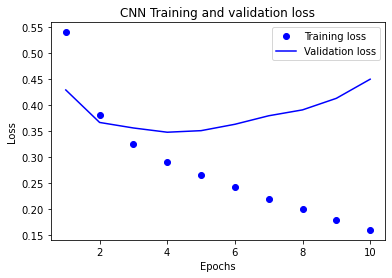

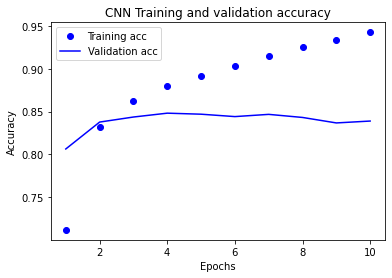

In [76]:
import matplotlib.pyplot as plt

acc = history_dict_CNN2['acc']
val_acc = history_dict_CNN2['val_acc']
loss = history_dict_CNN2['loss']
val_loss = history_dict_CNN2['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음




# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

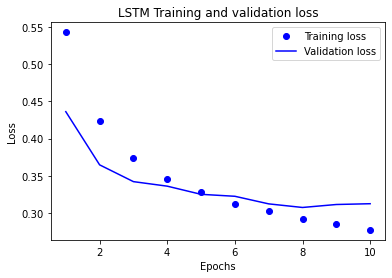

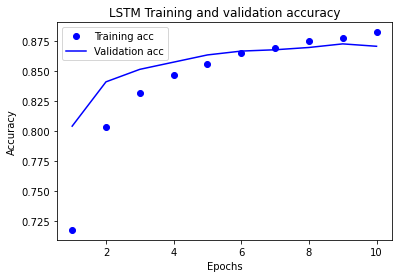

In [77]:
import matplotlib.pyplot as plt

acc = history_dict_LSTM2['acc']
val_acc = history_dict_LSTM2['val_acc']
loss = history_dict_LSTM2['loss']
val_loss = history_dict_LSTM2['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음




# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

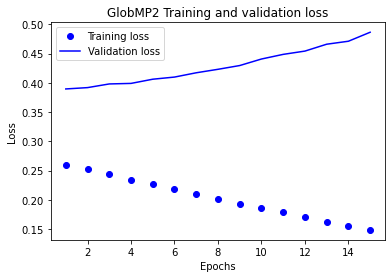

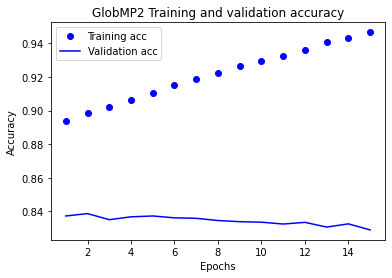

In [78]:
import matplotlib.pyplot as plt

acc = history_dict_GlobMP2['acc']
val_acc = history_dict_GlobMP2['val_acc']
loss = history_dict_GlobMP2['loss']
val_loss = history_dict_GlobMP2['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음




# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobMP2 Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobMP2 Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 한국어 임베딩 적용 전(노트북변경이전 그림)

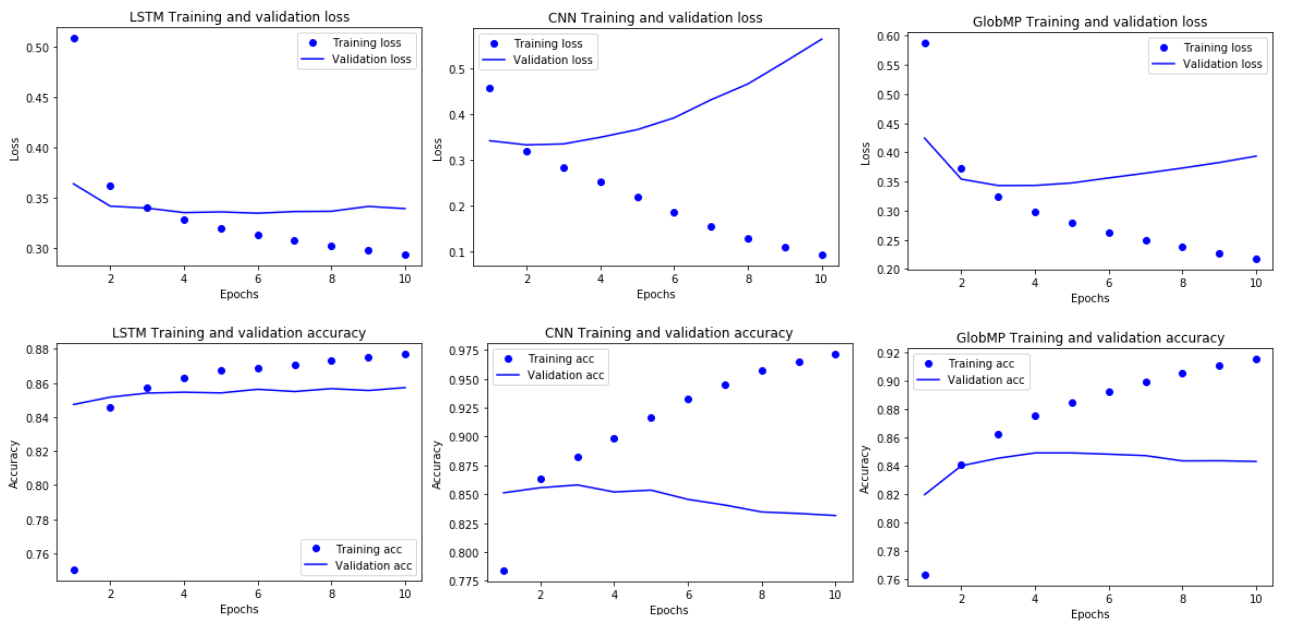

### 한국어 임베딩 적용 후(노트북변경이전 그림)

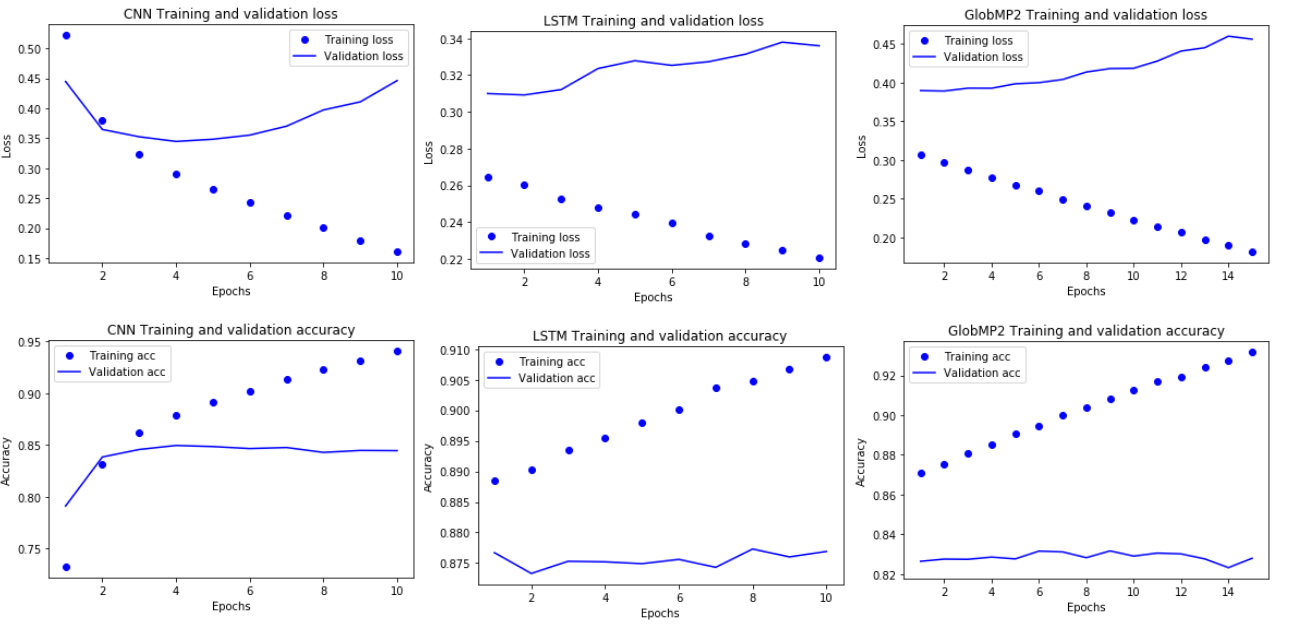

### accuracy와 loss (노트북변경이전  수치)
CNN : loss: 0.5680 - accuracy: 0.8317

LSTM :loss: 0.3519 - accuracy: 0.8503

GlobalMaxPooling :loss: 0.4056 - accuracy: 0.8389

-----------------------------------------------------
CNN :loss: 0.4690 - accuracy: 0.8386

LSTM : loss: 0.3519 - accuracy: 0.8716

GlobalMaxPooling : loss: 0.4580 - accuracy: 0.8251

word2vec한국어를 적용시 정확도에 대한 CNN은 대략0.002 상승, LSTM은 2.2상승, GlobalMaxPooling은 0.9 하락 하였다. 즉 '문자열에 대한 학습시 LSTM이 조금더 효율적이다'이라고 생각된다.



### accuracy와 loss (노트북변경이후 수치)

CNN : loss: 0.4295 - acc: 0.8384

LSTM : loss: 0.3537 - acc: 0.8497

GlobalMaxPooling : loss: 0.4035 - acc: 0.8399

------------------------------------------

CNN : loss: 0.4650 - acc: 0.8371

LSTM : loss: 0.3221 - acc: 0.8693

GlobalMaxPooling : loss: 0.4929 - acc: 0.8221


word2vec한국어를 적용시 정확도에 LSTM이 가장 많이 증가하였고 정확도도 가장 높다.